# Übung Trainieren und Bewerten eines Multiklassen-Klassifizierungsmodells

# Multiklassen-Klassifikation - Pinguine

**Ziel**: Pinguin-Art vorhersagen basierend auf physischen Merkmalen

**3 Klassen**:
- 0: Adelie
- 1: Gentoo  
- 2: Chinstrap

**Unterschied zu Binär**:
- 2 Klassen (0/1) → 3+ Klassen (0/1/2/...)
- Wird intern in binäre Probleme zerlegt (OVR oder OVO)
- Scikit-Learn macht das automatisch!

**Dataset**: Palmer Station Antarctica Pinguine


In [1]:
import pandas as pd

# Daten laden
penguins = pd.read_csv('penguins.csv')

# Zufällige Stichprobe
sample = penguins.sample(10)
print(sample)


     CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
309          51.0         18.8          203.0    4100.0        2
284          46.0         18.9          195.0    4150.0        2
169          49.2         15.2          221.0    6300.0        1
1            39.5         17.4          186.0    3800.0        0
92           34.0         17.1          185.0    3400.0        0
155          50.0         15.2          218.0    5700.0        1
203          48.5         14.1          220.0    5300.0        1
65           41.6         18.0          192.0    3950.0        0
326          48.1         16.4          199.0    3325.0        2
246          44.5         14.7          214.0    4850.0        1


## Dataset-Struktur

**Features** (physische Merkmale):
- `CulmenLength`: Schnabellänge (mm)
- `CulmenDepth`: Schnabeltiefe (mm)
- `FlipperLength`: Flossenlänge (mm)
- `BodyMass`: Körpermasse (g)

**Label**:
- `Species`: 0, 1, 2 (Pinguin-Art)

**Arten**:
- 0 = Adelie
- 1 = Gentoo
- 2 = Chinstrap


In [2]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')

# 10 Beispiele mit Namen anzeigen
for index, row in penguins.sample(10).iterrows():
    print('[', row[0], row[1], row[2], row[3], int(row[4]),']', 
          penguin_classes[int(row[4])])


['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 37.2 18.1 178.0 3900.0 0 ] Adelie
[ 39.7 18.4 190.0 3900.0 0 ] Adelie
[ 35.3 18.9 187.0 3800.0 0 ] Adelie
[ 41.5 18.3 195.0 4300.0 0 ] Adelie
[ 38.8 20.0 190.0 3950.0 0 ] Adelie
[ 47.5 16.8 199.0 3900.0 2 ] Chinstrap
[ 47.2 13.7 214.0 4925.0 1 ] Gentoo
[ 50.8 17.3 228.0 5600.0 1 ] Gentoo
[ 50.9 19.1 196.0 3550.0 2 ] Chinstrap
[ 37.6 17.0 185.0 3600.0 0 ] Adelie


/var/folders/p4/6l7rcw4x67141ht6vg1s_6pw0000gn/T/ipykernel_54675/2628241936.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('[', row[0], row[1], row[2], row[3], int(row[4]),']',
/var/folders/p4/6l7rcw4x67141ht6vg1s_6pw0000gn/T/ipykernel_54675/2628241936.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  penguin_classes[int(row[4])])


## Datenqualität prüfen

Gibt es fehlende Werte (NaN)?


In [3]:
# Fehlende Werte zählen
print(penguins.isnull().sum())


CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64


## Fehlende Werte anzeigen


In [4]:
# Zeilen mit NaN anzeigen
print(penguins[penguins.isnull().any(axis=1)])


     CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
3             NaN          NaN            NaN       NaN        0
271           NaN          NaN            NaN       NaN        1


## Fehlende Werte löschen

2 Zeilen haben komplett fehlende Features → unbrauchbar → löschen


In [5]:
# NaN-Zeilen entfernen
penguins = penguins.dropna()

# Bestätigen: Keine NaN mehr
print(penguins.isnull().sum())


CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64


## Feature-Verteilungen visualisieren

**Boxplots** zeigen, wie Features zwischen Arten variieren.

**Was suchen wir?**
- Unterschiede zwischen Arten
- Features, die gut trennen


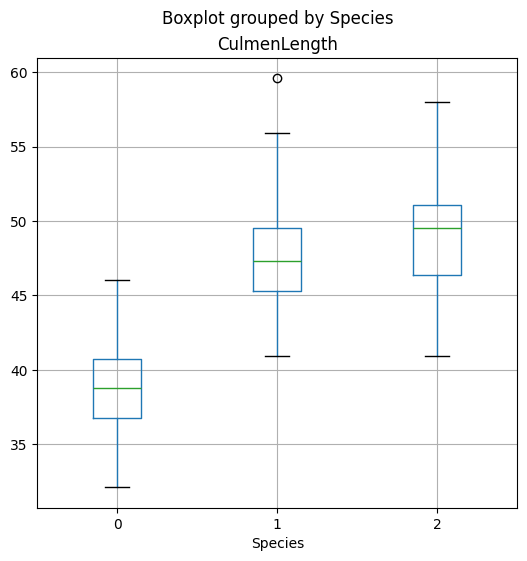

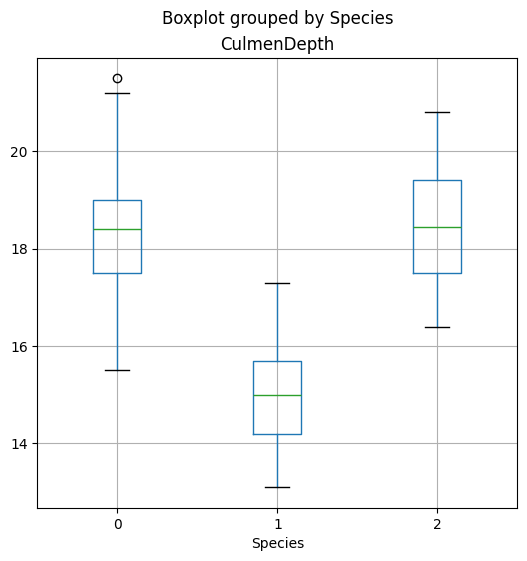

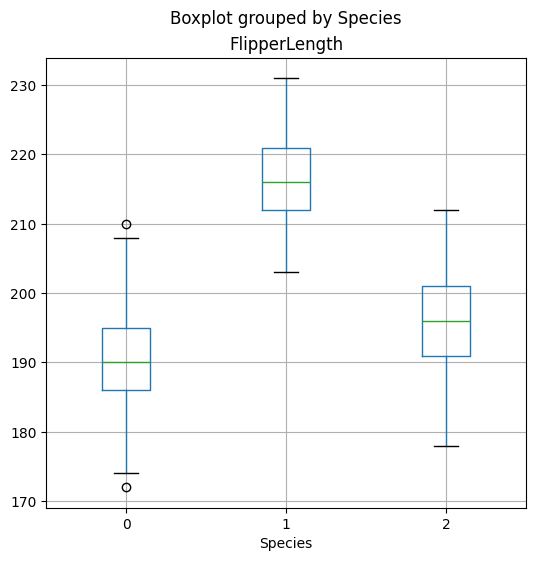

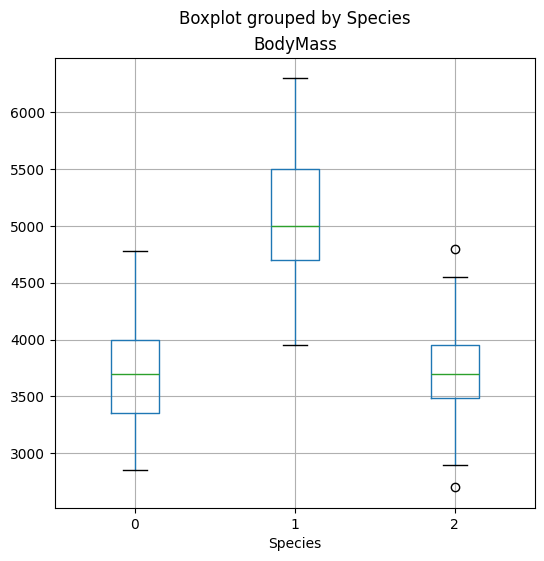

In [6]:
from matplotlib import pyplot as plt

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'

for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6,6))
    plt.title(col)
plt.show()


## Beobachtungen aus Boxplots

**Adelie (0) & Chinstrap (2)**:
- Ähnlich bei Culmen Depth, Flipper, Body Mass
- **Aber**: Chinstrap hat längeren Culmen (Schnabel)

**Gentoo (1)**:
- Deutlich unterschiedlich von anderen beiden
- Sollte leicht zu klassifizieren sein!

**→ Features sind prädiktiv!** ✅


## Train-Test-Split mit Stratifikation

**Stratifikation**: Erhält Proportion der Klassen in Train/Test

**Beispiel**: 
- Original: 33% Adelie, 33% Gentoo, 33% Chinstrap
- Mit Stratifikation: Train UND Test haben ~33/33/33
- Ohne: Könnte unbalanciert sein


In [7]:
from sklearn.model_selection import train_test_split

# Features und Labels trennen
penguins_X = penguins[penguin_features].values
penguins_y = penguins[penguin_label].values

# 70-30 Split mit Stratifikation
x_penguin_train, x_penguin_test, y_penguin_train, y_penguin_test = train_test_split(
    penguins_X, penguins_y,
    test_size=0.30,
    random_state=0,
    stratify=penguins_y  # WICHTIG!
)

print('Training Set: %d, Test Set: %d \n' % (x_penguin_train.shape[0], x_penguin_test.shape[0]))


Training Set: 239, Test Set: 103 



## Logistic Regression für Multiklasse

**Key Point**: Gleicher Code wie bei binärer Klassifikation!

**Scikit-Learn**:
- Erkennt automatisch 3 Klassen
- Verwendet OVR-Strategie intern
- `multi_class='auto'` wählt beste Methode


In [8]:
from sklearn.linear_model import LogisticRegression

reg = 0.1
multi_model = LogisticRegression(
    C=1/reg, 
    solver='lbfgs', 
    multi_class='auto', 
    max_iter=10000
).fit(x_penguin_train, y_penguin_train)

print(multi_model)


LogisticRegression(C=10.0, max_iter=10000, multi_class='auto')


/Users/sidarsarikaya/Documents/Python Code/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Vorhersagen

Vergleiche vorhergesagte mit echten Labels


In [9]:
penguin_predictions = multi_model.predict(x_penguin_test)
print('Predicted labels: ', penguin_predictions[:15])
print('Actual labels   : ', y_penguin_test[:15])


Predicted labels:  [0 1 0 2 2 1 1 1 0 2 2 1 2 1 2]
Actual labels   :  [0 1 2 2 2 1 1 1 0 2 2 1 2 1 2]


## Classification Report

**Multiklasse**: Precision/Recall für **jede Klasse**

**Wichtig**: 
- Macro Average = Durchschnitt über Klassen (ungewichtet)
- Weighted Average = Berücksichtigt Klassengrößen


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_penguin_test, penguin_predictions))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



## Gesamtmetriken

Bei Multiklasse: `average='macro'` für Gesamtprecision/Recall


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Overall Accuracy:", accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:", precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:", recall_score(y_penguin_test, penguin_predictions, average='macro'))


Overall Accuracy: 0.970873786407767
Overall Precision: 0.9688405797101449
Overall Recall: 0.9608465608465608


## Confusion Matrix (3x3)

**Statt 2x2 jetzt 3x3** (eine Zeile/Spalte pro Klasse)

**Diagonale** = Richtige Vorhersagen


In [12]:
from sklearn.metrics import confusion_matrix

mcm = confusion_matrix(y_penguin_test, penguin_predictions)
print(mcm)


[[44  0  1]
 [ 0 37  0]
 [ 2  0 19]]


## Confusion Matrix als Heatmap

**Dunklere Farben** = Mehr Fälle

**Diagonale dunkel** = Gut! ✅


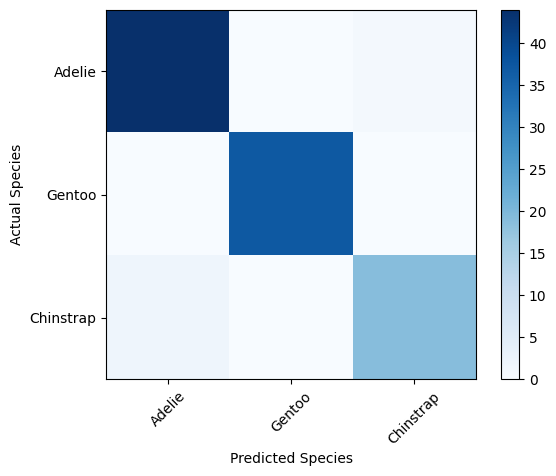

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()


## ROC-Kurve bei Multiklasse

**Problem**: Keine einzelne ROC-Kurve möglich

**Lösung**: OVR (One vs Rest)
- Adelie vs. Rest
- Gentoo vs. Rest
- Chinstrap vs. Rest

**→ 3 ROC-Kurven**


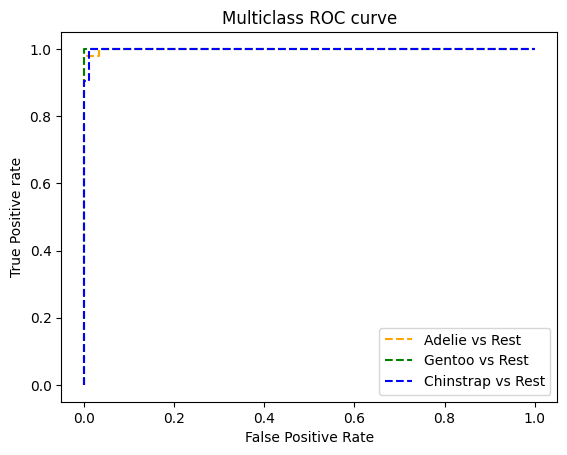

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# Wahrscheinlichkeiten
penguin_prob = multi_model.predict_proba(x_penguin_test)

# ROC für jede Klasse
fpr = {}
tpr = {}
thresh = {}
for i in range(len(penguin_classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_penguin_test, penguin_prob[:,i], pos_label=i)
    
# ROC-Kurven plotten
plt.plot(fpr[0], tpr[0], linestyle='--', color='orange', label=penguin_classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label=penguin_classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label=penguin_classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()


## AUC für Multiklasse

**Durchschnitt** über alle OVR-Kurven


In [15]:
auc = roc_auc_score(y_penguin_test, penguin_prob, multi_class='ovr')
print('Average AUC:', auc)


Average AUC: 0.9993574254297553


## Pipeline mit SVM

**Verbesserung**:
- StandardScaler für Features
- SVM statt Logistic Regression

**SVM** (Support Vector Machine): Findet optimale Trennebene zwischen Klassen


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Preprocessing
feature_columns = [0,1,2,3]
feature_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('preprocess', feature_transformer, feature_columns)
])

# Pipeline: Preprocessing + SVM
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVC(probability=True))  # probability=True für predict_proba
])

# Trainieren
multi_model = pipeline.fit(x_penguin_train, y_penguin_train)
print(multi_model)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', SVC(probability=True))])


## SVM-Modell evaluieren

Vergleich mit vorherigem Modell


Overall Accuracy: 0.9805825242718447
Overall Precision: 0.9767195767195768
Overall Recall: 0.9767195767195768
Average AUC: 0.9990361381446328


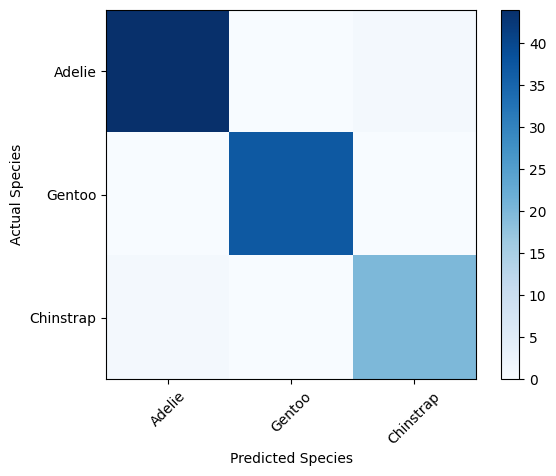

In [17]:
# Vorhersagen
penguin_predictions = multi_model.predict(x_penguin_test)
penguin_prob = multi_model.predict_proba(x_penguin_test)

# Metriken
print("Overall Accuracy:", accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:", precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:", recall_score(y_penguin_test, penguin_predictions, average='macro'))
print('Average AUC:', roc_auc_score(y_penguin_test, penguin_prob, multi_class='ovr'))

# Confusion Matrix
mcm = confusion_matrix(y_penguin_test, penguin_predictions)
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()


## Modell speichern


In [18]:
import joblib

filename = './penguin_model.pkl'
joblib.dump(multi_model, filename)
print(f"✅ Modell gespeichert: {filename}")


✅ Modell gespeichert: ./penguin_model.pkl


## Vorhersage für neuen Pinguin

**Einzelvorhersage**


In [19]:
# Modell laden
multi_model = joblib.load(filename)

# Neuer Pinguin: [CulmenLength, CulmenDepth, FlipperLength, BodyMass]
x_new = np.array([[50.4, 15.3, 224, 5550]])
print('New sample: {}'.format(x_new[0]))

# Vorhersage
penguin_pred = multi_model.predict(x_new)[0]
print('Predicted class is', penguin_classes[penguin_pred])


New sample: [  50.4   15.3  224.  5550. ]
Predicted class is Gentoo


## Batch-Vorhersage

**Mehrere Pinguine gleichzeitig**


In [20]:
# 2 Pinguine
x_new = np.array([
    [49.5, 18.4, 195, 3600],
    [38.2, 20.1, 190, 3900]
])
print('New samples:\n{}'.format(x_new))

# Vorhersagen
predictions = multi_model.predict(x_new)

for prediction in predictions:
    print(prediction, '(' + penguin_classes[prediction] + ')')


New samples:
[[  49.5   18.4  195.  3600. ]
 [  38.2   20.1  190.  3900. ]]
2 (Chinstrap)
0 (Adelie)


## Test: Batch-Vorhersage (2 Pinguine)

**Input**:
- Pinguin 1: [49.5, 18.4, 195, 3600]
- Pinguin 2: [38.2, 20.1, 190, 3900]

**Output**:
- Pinguin 1: Chinstrap (langer Schnabel: 49.5 mm)
- Pinguin 2: Adelie (kurzer Schnabel: 38.2 mm)

**Learning**: Modell nutzt Schnabellänge als Hauptkriterium! ✅


## ✅ Zusammenfassung

**Multiklassen-Klassifikation**:
- ✅ 3+ Klassen (hier: Adelie, Gentoo, Chinstrap)
- ✅ Gleicher Code wie binäre Klassifikation!
- ✅ Scikit-Learn macht OVR/OVO automatisch

**Key Learnings**:
1. **Stratifikation** bei Split: Erhält Klassenverhältnis
2. **Classification Report**: Metriken pro Klasse
3. **Confusion Matrix**: 3x3 statt 2x2
4. **ROC**: Eine Kurve pro Klasse (OVR)
5. **AUC**: Durchschnitt über alle Klassen

**Algorithmen getestet**:
- Logistic Regression (einfach, gut)
- SVM (komplexer, oft besser)

**Preprocessing**: StandardScaler verbessert Performance

**Real-World**: Modell speichern & für neue Daten verwenden

**Nächster Schritt**: Clustering (Unüberwachtes Lernen)! 🚀


# 🎓 Klassifikation - Modul Zusammenfassung

## Gelernt:
**Binäre Klassifikation**: 2 Klassen (0/1)
- Algorithmen: Logistic Regression, Random Forest, SVM
- Metriken: Accuracy, Precision, Recall, F1, AUC

**Multiklasse**: 3+ Klassen (0/1/2/...)
- Intern: OVR oder OVO
- Scikit-Learn: Automatisch!

**Wichtigste Erkenntnisse**:
- Accuracy allein reicht NICHT (bei unbalancierten Daten)
- Confusion Matrix zeigt wahre Fehler
- Precision vs Recall = Trade-off
- Pipelines = Preprocessing + Modell in einem
- ROC-AUC = Beste Gesamtmetrik

## Workflow:
1. Daten laden & bereinigen
2. Train-Test-Split (mit Stratifikation!)
3. Pipeline: Preprocessing + Algorithmus
4. Trainieren: `.fit(X_train, y_train)`
5. Vorhersagen: `.predict(X_test)`
6. Evaluieren: Confusion Matrix, Precision, Recall, AUC
7. Optimieren: Andere Algorithmen testen
8. Speichern: `joblib.dump(model, 'model.pkl')`

## Key Formulas:
- Accuracy = (TP+TN) / Total
- Precision = TP / (TP+FP)
- Recall = TP / (TP+FN)
- F1 = 2 × (Precision × Recall) / (Precision + Recall)

## Next Steps:
- Clustering (Unüberwachtes Lernen)
- Deep Learning
- Azure ML (No-Code Alternative)
